# Unit 5 - Financial Planning

In [139]:
# Initial imports
import os
import matplotlib.pyplot as plt
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [140]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [141]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [142]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [143]:
def getch_current_price(url):
    response = requests.get(url).json()
    return list(response['data'].values())[0]['quotes']['CAD']['price']

In [144]:
# Fetch current BTC price
btc_price = getch_current_price(btc_url)

# Fetch current ETH price
eth_price = getch_current_price(eth_url)

# Compute current value of my crpto
my_btc_value = my_btc * btc_price
my_eth_value = my_eth * eth_price
crypto_wallet_value = my_btc_value + my_eth_value

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")
print(f"The current value of your crypto wallet is ${crypto_value:0.2f}")

The current value of your 1.2 BTC is $31938.19
The current value of your 5.3 ETH is $11126.51
The current value of your crypto wallet is $43311.33


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [145]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [146]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2",
)

In [147]:
# Format current date as ISO format
today = pd.Timestamp('2022-09-13', tz='America/New_York').isoformat()

# Set the tickers
tickers = ['AGG', 'SPY']

# Set timeframe to "1Day" for Alpaca API
timeframe = '1Day'

# Get current closing prices for SPY and AGG
df = api.get_bars(
    tickers,
    timeframe,
    today,
    today
).df

# Reorganize the DataFrame
# Separate ticker data
agg_df = df.iloc[:1]
spy_df = df.iloc[1:]


# Concatenate the ticker DataFrames
df = pd.concat([agg_df, spy_df], axis=1)
df.drop('symbol', axis=1, inplace=True)
header = pd.MultiIndex.from_product([tickers, df.columns[:7]])
df.columns = header
# Preview DataFrame
df

AGG                                             \
                            open   high     low  close   volume trade_count   
timestamp                                                                     
2022-09-13 04:00:00+00:00  98.91  99.19  98.895  99.07  4832949       20103   

                                         SPY                                   \
                                vwap    open   high     low  close     volume   
timestamp                                                                       
2022-09-13 04:00:00+00:00  99.010168  401.64  403.1  391.92  393.1  122318529   

                                                   
                          trade_count        vwap  
timestamp                                          
2022-09-13 04:00:00+00:00      789029  398.857113

In [148]:
# Pick AGG and SPY close prices
def get_close_price(df, ticker):
    return df[ticker]['close'].values[0]

agg_close_price = get_close_price(df, 'AGG')
spy_close_price = get_close_price(df, 'SPY')

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $99.07
Current SPY closing price: $393.1


In [149]:
# Compute the current value of shares
my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price
my_shares_value = my_spy_value + my_agg_value

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")
print(f"The current value of your shares is ${my_portfolio_value:0.2f}")

The current value of your 50 SPY shares is $19655.00
The current value of your 200 AGG shares is $19814.00
The current value of your shares is $39469.00


### Savings Health Analysis

In [150]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
# Create savings DataFrame
df_savings = pd.DataFrame(
    {'amount': [crypto_wallet_value, my_portfolio_value]},
    index=['crypto', 'shares']
)

# Display savings DataFrame
display(df_savings)

,amount
crypto,43064.70036
shares,39469.00000


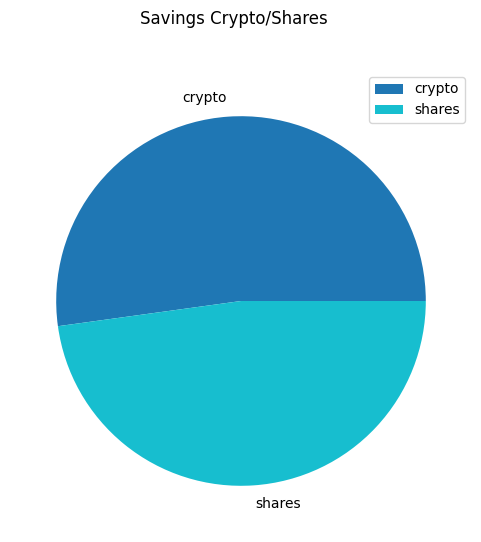

In [151]:
# Plot savings pie chart
df_savings.plot(
    kind='pie', subplots=True,
    title='Savings Crypto/Shares',
    figsize=(6, 6), colormap='tab10',
    ylabel=''
);

In [152]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = df_savings.sum().values[0]

# Validate saving health
if total_savings > emergency_fund:
    print('Congratulations on having enough money in this fund.')
elif total_savings == emergency_fund:
    print('Congratulations on reaching your financial goal.')
else:
    print(f'You are ${emergency_fund - total_savings} away from reaching your goal in your emergency fund.')

Congratulations on having enough money in this fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [153]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2017-09-13', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2022-09-13', tz='America/New_York').isoformat()

In [154]:
# Get 5 years' worth of historical data for SPY and AGG
df_stock_data = api.get_bars(
    tickers,
    timeframe,
    start_date,
    end_date
).df

# Reorganize the DataFrame
# Separate ticker data
agg_df = df_stock_data[df_stock_data.symbol == 'AGG']
spy_df = df_stock_data[df_stock_data.symbol == 'SPY']

# Concatenate the ticker DataFrames
df_stock_data = pd.concat([agg_df, spy_df], axis=1)
df_stock_data.drop('symbol', axis=1, inplace=True)
header = pd.MultiIndex.from_product([tickers, df_stock_data.columns[:7]])
df_stock_data.columns = header
# Display sample data
df_stock_data.head()

AGG                                     \
                             open    high       low   close   volume   
timestamp                                                              
2017-09-13 04:00:00+00:00  110.00  110.04  109.8600  109.87  1304102   
2017-09-14 04:00:00+00:00  109.81  109.97  109.8100  109.93  1704216   
2017-09-15 04:00:00+00:00  110.00  110.04  109.8600  109.91  2818046   
2017-09-18 04:00:00+00:00  109.86  109.90  109.7705  109.86  1946411   
2017-09-19 04:00:00+00:00  109.91  109.96  109.7850  109.80  1407196   

                                                      SPY                  \
                          trade_count        vwap    open    high     low   
timestamp                                                                   
2017-09-13 04:00:00+00:00        6565  109.926598  249.73  250.21  249.59   
2017-09-14 04:00:00+00:00        7111  109.914840  249.83  250.32  249.60   
2017-09-15 04:00:00+00:00        7997  109.928798  248.70  249.29  248.57   
2017-09-18 04:00:00+00:00       10215  109.835088  249.62  250.12  249.28   
2017-09-19 04:00:00+00:00        7601  109.836548  250.00  250.07  249.60   

                                                                     
                            close    volume trade_count        vwap  
timestamp                                                            
2017-09-13 04:00:00+00:00  250.17  59228002      147055  250.040408  
2017-09-14 04:00:00+00:00  250.09  95446349      188794  250.052841  
2017-09-15 04:00:00+00:00  249.19  95432382      186880  249.026860  
2017-09-18 04:00:00+00:00  249.72  46230238      160259  249.698053  
2017-09-19 04:00:00+00:00  249.97  47108148      125388  249.877595

In [155]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30_years = MCSimulation(
    portfolio_data=df_stock_data, weights=[.4, .6],
    num_simulation=500, num_trading_days=252 * 30
)

In [156]:
# Printing the simulation input data
MC_30_years.portfolio_data.head()

AGG                                     \
                             open    high       low   close   volume   
timestamp                                                              
2017-09-13 04:00:00+00:00  110.00  110.04  109.8600  109.87  1304102   
2017-09-14 04:00:00+00:00  109.81  109.97  109.8100  109.93  1704216   
2017-09-15 04:00:00+00:00  110.00  110.04  109.8600  109.91  2818046   
2017-09-18 04:00:00+00:00  109.86  109.90  109.7705  109.86  1946411   
2017-09-19 04:00:00+00:00  109.91  109.96  109.7850  109.80  1407196   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2017-09-13 04:00:00+00:00        6565  109.926598          NaN  249.73   
2017-09-14 04:00:00+00:00        7111  109.914840     0.000546  249.83   
2017-09-15 04:00:00+00:00        7997  109.928798    -0.000182  248.70   
2017-09-18 04:00:00+00:00       10215  109.835088    -0.000455  249.62   
2017-09-19 04:00:00+00:00        7601  109.836548    -0.000546  250.00   

                                                                         \
                             high     low   close    volume trade_count   
timestamp                                                                 
2017-09-13 04:00:00+00:00  250.21  249.59  250.17  59228002      147055   
2017-09-14 04:00:00+00:00  250.32  249.60  250.09  95446349      188794   
2017-09-15 04:00:00+00:00  249.29  248.57  249.19  95432382      186880   
2017-09-18 04:00:00+00:00  250.12  249.28  249.72  46230238      160259   
2017-09-19 04:00:00+00:00  250.07  249.60  249.97  47108148      125388   

                                                    
                                 vwap daily_return  
timestamp                                           
2017-09-13 04:00:00+00:00  250.040408          NaN  
2017-09-14 04:00:00+00:00  250.052841    -0.000320  
2017-09-15 04:00:00+00:00  249.026860    -0.003599  
2017-09-18 04:00:00+00:00  249.698053     0.002127  
2017-09-19 04:00:00+00:00  249.877595     0.001001

In [157]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30_years.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.012787,0.993048,0.983634,0.999004,0.990238,1.002209,0.995289,1.001247,1.008951,0.993636,...,0.981352,1.006275,0.985569,0.999738,1.004210,0.997101,0.995498,0.989410,1.004298,0.988663
2,1.009714,0.993838,0.988810,0.990715,0.993241,0.994318,0.993711,0.996709,1.010771,1.003138,...,0.986378,0.998632,0.983123,0.995736,1.006750,0.986827,0.996745,0.995718,1.016851,1.002957
3,1.002477,0.986476,1.002512,0.992794,1.000888,0.991585,0.993270,1.003788,1.002657,1.001907,...,0.997961,1.003080,0.983436,0.984472,1.011562,0.982924,0.992466,0.995044,1.012085,1.003245
4,1.010923,0.990816,1.006955,0.987829,0.999800,0.995910,0.995027,1.020781,1.001740,1.002636,...,0.996512,1.004344,0.976205,0.984042,1.002679,0.980532,0.996099,1.006722,1.018951,0.999658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,2.995791,23.648593,11.893171,2.327213,12.865228,5.058768,4.082699,2.038273,4.828069,3.474273,...,2.534255,4.934547,3.626241,6.877160,9.649273,14.659391,3.806557,4.321999,3.576355,18.249712
7557,2.995750,23.698998,11.719932,2.312787,13.023332,5.082158,4.154302,2.052576,4.802790,3.420703,...,2.543625,4.983996,3.675632,6.915456,9.625378,14.702954,3.819305,4.307983,3.542147,18.291301
7558,3.008426,23.685621,11.844662,2.317401,12.891576,5.023513,4.180155,2.053527,4.752927,3.427667,...,2.536536,4.956684,3.658029,6.991210,9.589605,14.769947,3.825546,4.347970,3.568889,18.321045
7559,3.004197,23.618001,11.746154,2.306619,13.018023,5.085078,4.225839,2.042500,4.666700,3.439707,...,2.545603,5.017831,3.642583,6.991016,9.448511,14.833286,3.873563,4.435643,3.555358,18.480280


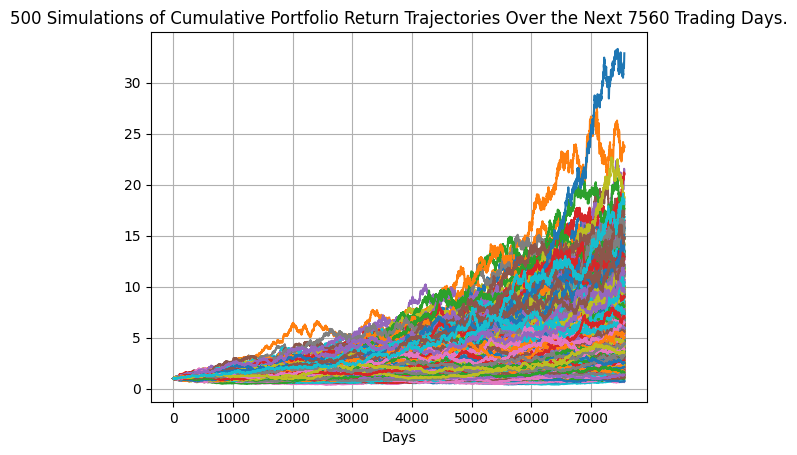

In [158]:
# Plot simulation outcomes
MC_30_years.plot_simulation()
plt.xlabel('Days')
plt.grid(True);

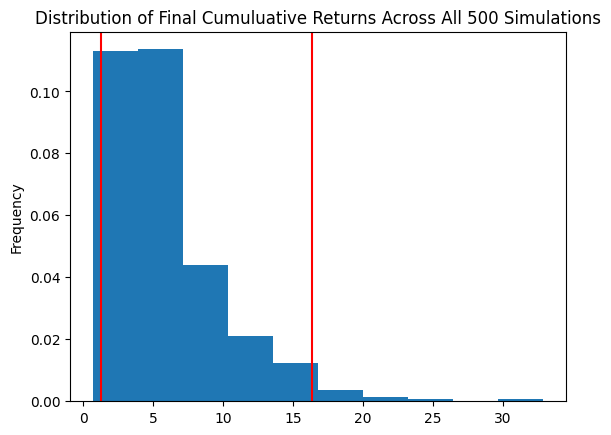

In [159]:
# Plot probability distribution and confidence intervals
MC_30_years.plot_distribution();

### Retirement Analysis

In [160]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_sum = MC_30_years.summarize_cumulative_return()

# Print summary statistics
print(MC_sum)

count           500.000000
mean              5.861453
std               4.109574
min               0.657837
25%               2.951746
50%               4.794712
75%               7.397482
max              32.883330
95% CI Lower      1.281446
95% CI Upper     16.322384
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [161]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(MC_sum['95% CI Lower'] * initial_investment, 2)
ci_upper = round(MC_sum['95% CI Upper'] * initial_investment, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $25628.92 and $326447.69


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [162]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(MC_sum['95% CI Lower'] * initial_investment, 2)
ci_upper = round(MC_sum['95% CI Upper'] * initial_investment, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $38443.39 and $489671.53


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [163]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_years = MCSimulation(
    portfolio_data=df_stock_data, weights=[.2, .8],
    num_simulation=500, num_trading_days=252 * 5
)

In [164]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_years.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998695,0.991575,0.990152,0.995466,1.011024,1.003244,1.007188,0.987784,0.998280,1.016304,...,1.002565,0.990345,1.006556,1.001680,1.006048,0.987609,0.993317,0.995331,0.997713,0.988451
2,0.996681,1.000911,0.996150,0.981800,1.000510,0.994277,1.016362,0.983228,1.010578,1.009577,...,1.027879,1.001273,1.016809,0.995156,1.018401,0.982447,1.018647,0.996537,0.997691,0.998074
3,0.993296,0.988868,1.013711,0.983016,0.999621,0.990280,0.999201,0.981803,0.992751,1.015612,...,1.025556,0.988663,1.016281,0.972795,1.033403,0.970684,1.025723,1.001484,1.004942,1.017279
4,0.980214,0.973810,1.004672,0.981315,0.998966,0.990583,1.000591,0.973915,0.999219,1.009221,...,1.032925,0.988079,1.016191,0.982975,1.020691,0.966498,1.014160,0.997292,0.996625,1.029553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,3.161726,0.858785,2.645532,2.128334,1.691143,2.289524,1.142251,0.866978,1.187372,1.410210,...,1.734057,3.163033,2.022000,1.915818,0.887642,1.657877,2.031637,1.002464,1.082565,0.883425
1257,3.138972,0.865420,2.686792,2.176742,1.687656,2.271230,1.135189,0.863937,1.195200,1.405955,...,1.743431,3.159738,2.033190,1.916916,0.885442,1.668152,2.042613,1.007690,1.077683,0.897363
1258,3.124159,0.896632,2.667037,2.173665,1.720682,2.258729,1.153231,0.864373,1.205490,1.411545,...,1.731057,3.158080,1.996858,1.938415,0.882673,1.649556,2.065930,1.013382,1.085033,0.880638
1259,3.134275,0.905161,2.639452,2.176724,1.733827,2.269127,1.151767,0.858264,1.211162,1.416538,...,1.748064,3.219046,2.018213,1.959452,0.882309,1.658279,2.038268,1.015700,1.090138,0.860368


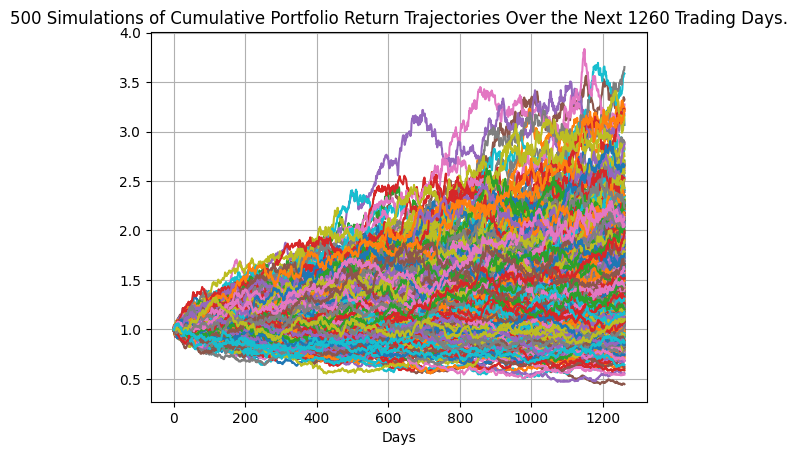

In [165]:
# Plot simulation outcomes
MC_5_years.plot_simulation()
plt.xlabel('Days')
plt.grid(True);

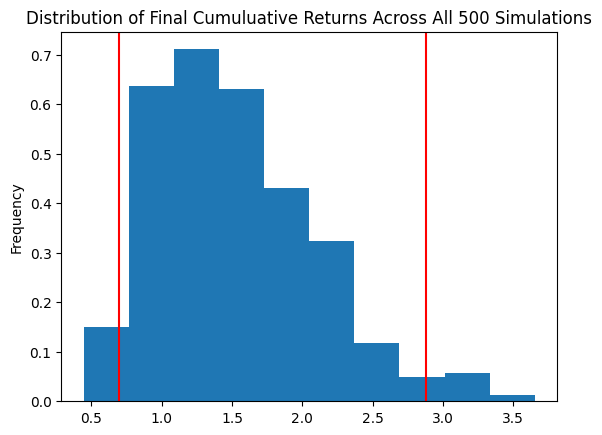

In [166]:
# Plot probability distribution and confidence intervals
MC_5_years.plot_distribution();

In [167]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_sum_5 = MC_5_years.summarize_cumulative_return()

# Print summary statistics
print(MC_sum_5)

count           500.000000
mean              1.527861
std               0.573320
min               0.446063
25%               1.084991
50%               1.439248
75%               1.883822
max               3.652936
95% CI Lower      0.697542
95% CI Upper      2.880724
Name: 1260, dtype: float64


In [168]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(MC_sum_5['95% CI Lower'] * initial_investment, 2)
ci_upper_five = round(MC_sum_5['95% CI Upper'] * initial_investment, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 5 years will end within in the range of $13950.84 and $57614.47


### Ten Years Retirement Option

In [169]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_10_years = MCSimulation(
    portfolio_data=df_stock_data, weights=[.2, .8],
    num_simulation=500, num_trading_days=252 * 30
)

In [170]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_10_years.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.984221,0.987533,0.999430,1.007950,0.971665,0.986531,0.992695,1.005048,1.003438,1.005959,...,0.986936,1.005992,1.014865,0.982413,1.005541,1.005156,0.992053,1.008387,1.002495,1.014622
2,0.999036,0.995010,1.010630,1.021549,0.980487,0.993030,0.992551,0.990269,1.017683,1.004116,...,0.981331,1.007061,1.024887,0.986608,1.008617,0.986767,1.004895,1.019299,1.011198,1.002295
3,0.982397,1.012773,1.007322,1.018099,0.985370,0.983292,0.972726,0.989255,1.029950,1.006314,...,0.990645,1.007304,1.019020,0.982796,1.018193,0.985412,1.011501,1.005813,1.021408,0.995227
4,0.979342,0.996076,1.013615,1.006361,0.980101,0.987885,0.960420,0.996212,1.040574,1.023435,...,0.997636,1.021124,1.039309,0.993936,1.016098,0.994143,1.013601,0.996035,1.021414,1.009203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,18.182358,25.441147,7.367213,25.765807,1.983417,25.689530,5.796294,37.551171,33.922184,10.068460,...,8.156762,3.086383,20.686095,1.989374,3.394682,29.001505,0.638270,29.445269,15.203266,18.782398
7557,18.240455,25.357931,7.332246,26.295935,1.966415,25.008676,5.727304,37.613067,34.748315,10.022760,...,8.289793,3.022096,20.558123,2.017017,3.425749,29.063277,0.636224,28.762404,15.191288,18.592200
7558,18.272102,25.522731,7.327143,26.579601,1.966126,25.115032,5.681203,37.894594,34.637006,10.074059,...,8.143959,2.966774,19.816585,1.994138,3.415806,29.559519,0.621161,29.124062,15.157855,18.953670
7559,18.157028,25.190877,7.320926,27.068743,1.978004,25.143518,5.770764,36.833565,34.239323,10.070801,...,8.097631,2.975545,19.808483,1.998083,3.394678,29.713148,0.626109,28.929397,15.306202,19.459145


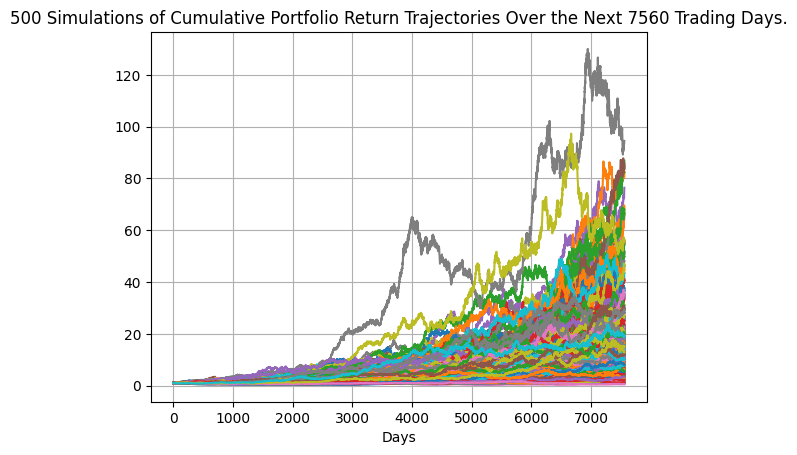

In [171]:
# Plot simulation outcomes
MC_10_years.plot_simulation()
plt.xlabel('Days')
plt.grid(True);

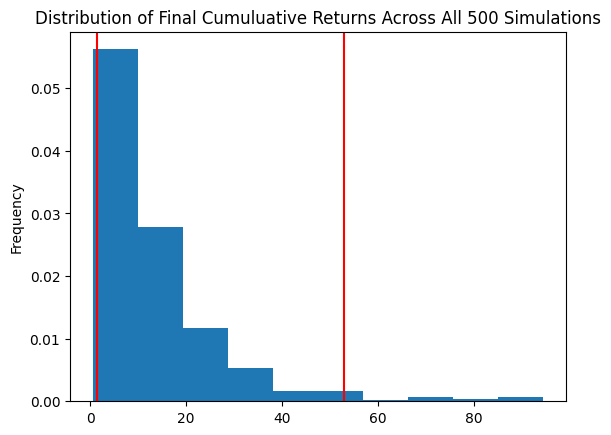

In [172]:
# Plot probability distribution and confidence intervals
MC_10_years.plot_distribution();

In [173]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_sum_10 = MC_10_years.summarize_cumulative_return()

# Print summary statistics
print(MC_sum_10)

count           500.000000
mean             13.524934
std              13.516465
min               0.523749
25%               5.061197
50%               9.048463
75%              17.085575
max              94.479670
95% CI Lower      1.489455
95% CI Upper     52.878627
Name: 7560, dtype: float64


In [174]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(MC_sum_10['95% CI Lower'] * initial_investment, 2)
ci_upper_ten = round(MC_sum_10['95% CI Upper'] * initial_investment, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 10 years will end within in the range of $29789.11 and $1057572.53
